In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.models.rnn import predict_mean_returns_rnn
from src.optimization.markowitz import solve_markowitz, minimize_volatility
from src.data.loader import load_prices, compute_returns
from outputs.charts.markowitz_plot import plot_efficient_frontier
from src.models.lr import predict_mean_returns
import pandas as pd


In [2]:
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"] # "MGLU3.SA"
start_date = "2017-01-01"
end_date = "2025-06-01"

# Frequência desejada: 'daily', 'weekly', 'monthly', 'annual'
#frequencia_retorno = 'monthly'
#target_return = 0.01
risk_free_rate = 0.15

In [3]:
prices = load_prices(tickers, start=start_date, end=end_date)

returns_daily = compute_returns(prices, freq='daily')
returns_monthly = compute_returns(prices, freq='monthly')
returns_annually = compute_returns(prices, freq='annually')

mean_returns_daily = returns_daily.mean()
cov_matrix_daily = returns_daily.cov()

mean_returns_monthly = returns_monthly.mean()
cov_matrix_monthly = returns_monthly.cov()

mean_returns_annually = returns_annually.mean()
cov_matrix_annually = returns_annually.cov()


/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


Retornos esperados (RNN):
ABEV3.SA   -0.001599
B3SA3.SA    0.002316
BBAS3.SA    0.002259
BBDC4.SA    0.002064
GGBR4.SA   -0.001231
ITUB4.SA    0.002198
PETR4.SA    0.002603
VALE3.SA    0.001627
WEGE3.SA    0.002560
Name: Predicted_RNN_Mean_Returns, dtype: float64


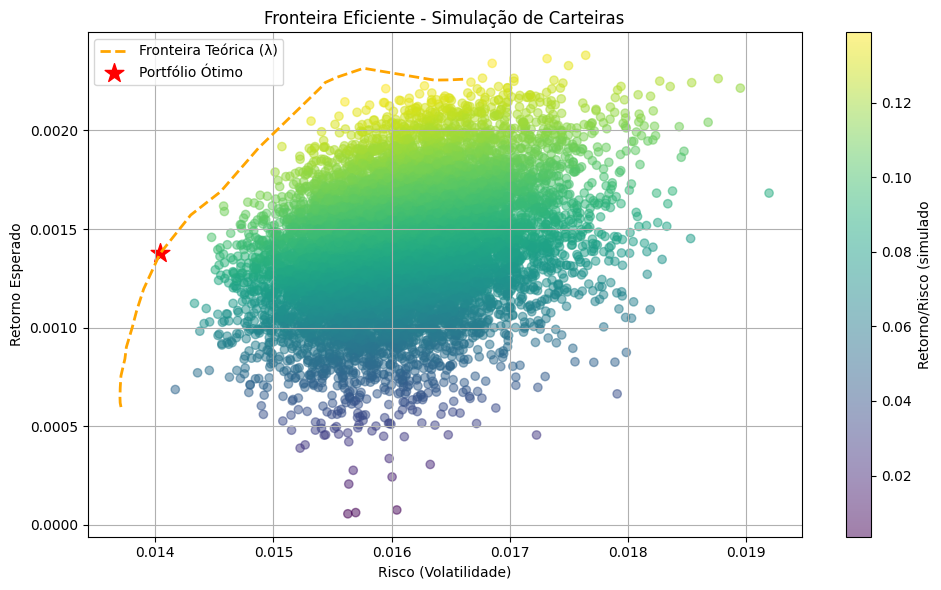

In [4]:
pred_rnn = predict_mean_returns_rnn(prices, window=5, seq_len=20)

print("Retornos esperados (RNN):")
print(pred_rnn)

# Usar no Markowitz (mesmo esquema do LR)
weights_rnn = solve_markowitz(pred_rnn, cov_matrix_daily, lamb=0.5)

plot_efficient_frontier(pred_rnn, cov_matrix_daily, optimized_weights=weights_rnn)


In [5]:
from src.models.rnn import evaluate_rnn_model

eval_rnn = evaluate_rnn_model(prices, window=5, seq_len=20)
print(eval_rnn)


     Ticker       MSE        R²  Correlação
0  ABEV3.SA  0.000378 -1.069119   -0.054095
1  B3SA3.SA  0.000632 -0.520548    0.023533
2  BBAS3.SA  0.000541 -2.032808   -0.099091
3  BBDC4.SA  0.000563 -0.670157    0.027789
4  GGBR4.SA  0.000676 -1.092743   -0.020086
5  ITUB4.SA  0.000536 -2.550707    0.025734
6  PETR4.SA  0.000679 -1.578326   -0.045603
7  VALE3.SA  0.000506 -1.303323    0.093357
8  WEGE3.SA  0.000550 -0.678995    0.006055


In [7]:
print(eval_rnn)
print(eval_rnn.describe())

     Ticker       MSE        R²  Correlação
0  ABEV3.SA  0.000378 -1.069119   -0.054095
1  B3SA3.SA  0.000632 -0.520548    0.023533
2  BBAS3.SA  0.000541 -2.032808   -0.099091
3  BBDC4.SA  0.000563 -0.670157    0.027789
4  GGBR4.SA  0.000676 -1.092743   -0.020086
5  ITUB4.SA  0.000536 -2.550707    0.025734
6  PETR4.SA  0.000679 -1.578326   -0.045603
7  VALE3.SA  0.000506 -1.303323    0.093357
8  WEGE3.SA  0.000550 -0.678995    0.006055
            MSE        R²  Correlação
count  9.000000  9.000000    9.000000
mean   0.000562 -1.277414   -0.004712
std    0.000094  0.676417    0.056755
min    0.000378 -2.550707   -0.099091
25%    0.000536 -1.578326   -0.045603
50%    0.000550 -1.092743    0.006055
75%    0.000632 -0.678995    0.025734
max    0.000679 -0.520548    0.093357


In [6]:
from src.optimization.evaluation import evaluate_portfolio

results_rnn = evaluate_portfolio(
    returns=returns_daily,
    weights=weights_rnn,
    freq='daily',
    model_name='rnn_metrics',
)

pd.DataFrame([results_rnn]).to_csv("../outputs/models/rnn_metrics.csv", index=False)
